# TI3130: Unsupervised Learning &mdash; Tutorial
**Julián Urbano &mdash; January 2022**

## 1. Introduction

The purpose of this lab is to introduce you to clustering and PCA analysis in Python. Just as we did in the _Classification_ lab, we will use package [Scikit-learn](https://scikit-learn.org/). As usual, we will use NumPy, Pandas and Plotnine where necessary, as well as Statsmodels near the end.

In [1]:
import sys
import numpy as np
import pandas as pd
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

python 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)] 
numpy 1.21.2 
pandas 1.3.5 
plotnine 0.8.0 
statsmodels 0.13.0 
sklearn 0.24.2


For this lab we will use the _Heart disease_ dataset, as well as the _Whiskey taste_ dataset. Note that we again convert string-like variables into categorical columns.

In [2]:
heart = pd.read_csv('heart.csv')
for col in heart.select_dtypes('object').columns:
    heart[col] = pd.Categorical(heart[col])
heart.info()

whiskey = pd.read_csv('whiskey.csv')
for col in whiskey.select_dtypes('object').columns:
    whiskey[col] = pd.Categorical(whiskey[col])
whiskey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ahd        297 non-null    category
 1   age        297 non-null    int64   
 2   sex        297 non-null    category
 3   chestpain  297 non-null    category
 4   restbp     297 non-null    int64   
 5   chol       297 non-null    int64   
 6   fbs        297 non-null    category
 7   restecg    297 non-null    category
 8   maxhr      297 non-null    int64   
 9   exang      297 non-null    category
 10  oldpeak    297 non-null    float64 
 11  slope      297 non-null    category
 12  ca         297 non-null    int64   
 13  thal       297 non-null    category
dtypes: category(8), float64(1), int64(5)
memory usage: 17.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      -------------

## 2. K-means Clustering

We can perform k-means clustering with Scikit-learn's [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Contrary to other algorithms, we do not specify the model with a formula-like expression, nor with an `X` and a `y`, because there is no notion of dependent and independent variables. Instead, `KMeans` simply receives a dataset we want to cluster with, and it will use _all_ variables in it. If we want to cluster only according to some variables, we'll need to make that explicit by passing a dataframe with a subset of columns.

Let's see how well k-means clustering works in grouping whiskey brands by `latitude` and `longitude` alone. The geographical distribution of whiskeys is as follows:

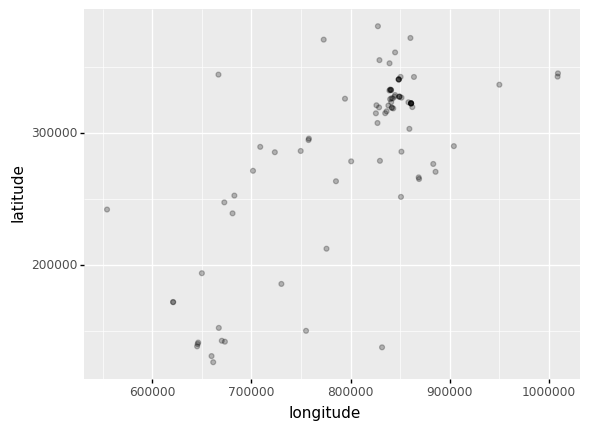

<ggplot: (137798825701)>

In [3]:
ggplot(whiskey, aes('longitude', 'latitude')) +\
  geom_point(alpha = .25)

There seem to be two or three clusters, so let's try both through argument `n_clusters`. As with SVM models, it's a good idea to standardize the features prior to clustering, to avoid some features having a large impact only because of units or magnitudes.

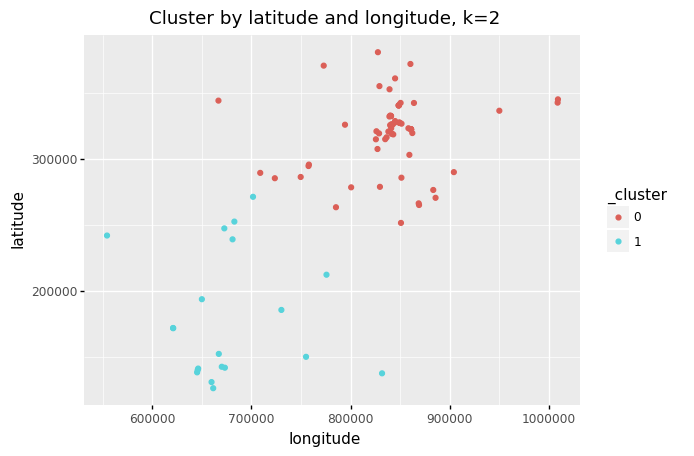

<ggplot: (137799475737)>

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# selection of columns 
X = whiskey[['longitude', 'latitude']]
# standardize so all columns have zero mean and unit variance
X_scaled = StandardScaler().fit(X).transform(X)

# run k-means clustering with k=2
# we set the random_state for reproducibility
m = KMeans(n_clusters = 2, random_state = 12345).fit(X_scaled) 

# create a new categorical column for the cluster
whiskey['_cluster'] = pd.Categorical(m.labels_)

# plot the data using colors to identify clusters
ggplot(whiskey, aes('longitude', 'latitude', color = '_cluster')) +\
  geom_point() +\
  labs(title = "Cluster by latitude and longitude, k=2")

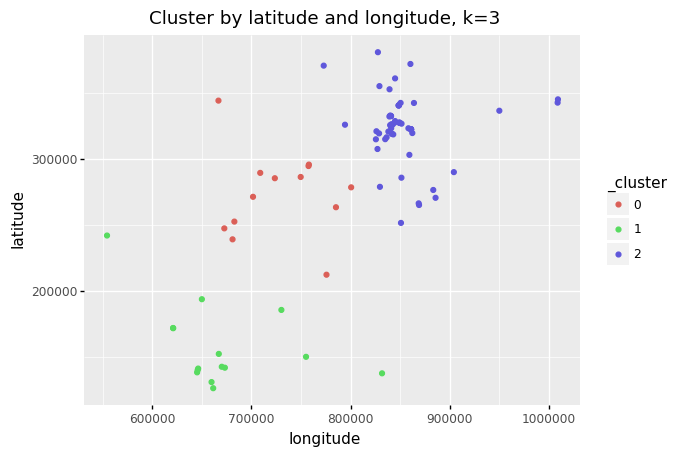

<ggplot: (137798823331)>

In [5]:
# run k-means clustering with k=3
m = KMeans(n_clusters = 3, random_state = 12345).fit(X_scaled) 
whiskey['_cluster'] = pd.Categorical(m.labels_)

ggplot(whiskey, aes('longitude', 'latitude', color = '_cluster')) +\
  geom_point() +\
  labs(title = "Cluster by latitude and longitude, k=3")

Note that we set a `random_state` so that we can reproduce our results (different states can potentially lead to different clusters, because the initialization is different). Note also that we selected only two variables for clustering (`longitude` and `latitude`, because we are interested in geographical clusters), but in general one would cluster with all available data. Finally, note that, after the algorithm figures out the clusters for us, we create a new column `_cluster` in the data frame, which identifies which cluster each row belongs to.

We can always check how good the clusters are by looking at the within-cluster sum of squares, which is accessible through attribute `inertia_`. Let's try $k$ from 2 up to 10:

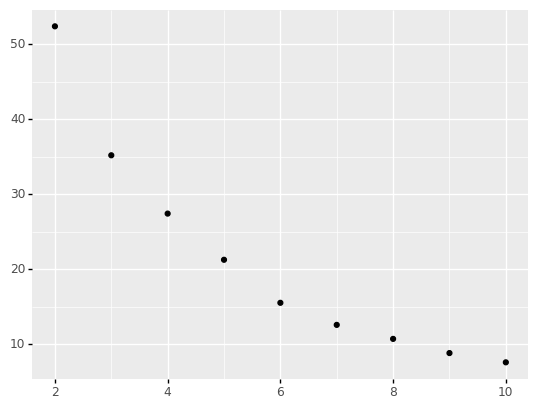

<ggplot: (137799504514)>

In [6]:
K = range(2, 11)
withinSS = []

# create models and calculate scores
for k in K:
    m = KMeans(n_clusters = k, random_state = 12345).fit(X_scaled) 
    # access to the total sum of squares directly from the model
    withinSS.append(m.inertia_)

# plot the scores
ggplot(aes(K, withinSS)) +\
  geom_point()

It looks like 5 or 6 clusters are appropriate, but recall that we are clustering only based on `latitude` and `longitude`, which is probably not very useful. Let's cluster according to the 12 taste scores and check more values for $k$:

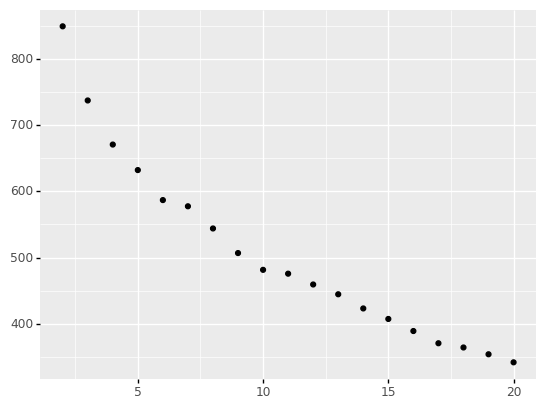

<ggplot: (137799593379)>

In [7]:
# select and scale the 12 taste variables
X = whiskey.loc[:, 'body':'floral']
X_scaled = StandardScaler().fit(X).transform(X)

K = range(2, 21)
withinSS = []

# create models and calculate scores
for k in K:
    m = KMeans(n_clusters = k, random_state = 12345).fit(X_scaled) 
    withinSS.append(m.inertia_)

# plot the scores
ggplot(aes(K, withinSS)) +\
  geom_point()

Note that we use all columns between `body` and `floral`, which are the 12 taste ratings. In this case there is no clear elbow, so we would have to choose $k$ based on some other criteria, probably involving domain knowledge.

## 3. Hierarchical Clustering

Alternatively, we can use hierarchical clustering to come up with a tree-like structure that we can prune afterwards. For this we will use Scikit-learn's [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). We can run it directly specifying how many clusters we want to end up with, such that the tree will be pruned as necessary. Let's try with $k$=3:

In [8]:
from sklearn.cluster import AgglomerativeClustering

# cluster with the re-scaled features
m = AgglomerativeClustering(n_clusters = 3).fit(X_scaled)
m.labels_ # these are the clusters

array([2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1,
       0, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 2,
       0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

The advantage of hierarchical clustering though, is that we can decide a suitable number of clusters after taking a look at the full dendrogram, so we should first run the algorithm with argument `compute_full_tree = True`. Unfortunately, Scikit-learn does not have a built-in visualization function, but [they recommend](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html) using Scipy's [`dendrogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) through the following custom function (as with the cross-validation function `kfold_cv` in the _Classification_ lab, you don't need to understand this function, but just how to use it).

In [9]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

def plot_dendrogram(model, labels, figsize=(14,6), **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(14,6))
    dendrogram(linkage_matrix, color_threshold = 0, leaf_rotation = 90, labels=labels, **kwargs)

We pass to the function the clustering `model` we want to visualize, and the `labels` of the instances, to quickly identify them in the dendrogram. This function requires us to run the clustering algorithm with argument `compute_distances = True` in order to make the length of a branch match the distance between its children.

Let's build the full clustering tree and plot it:

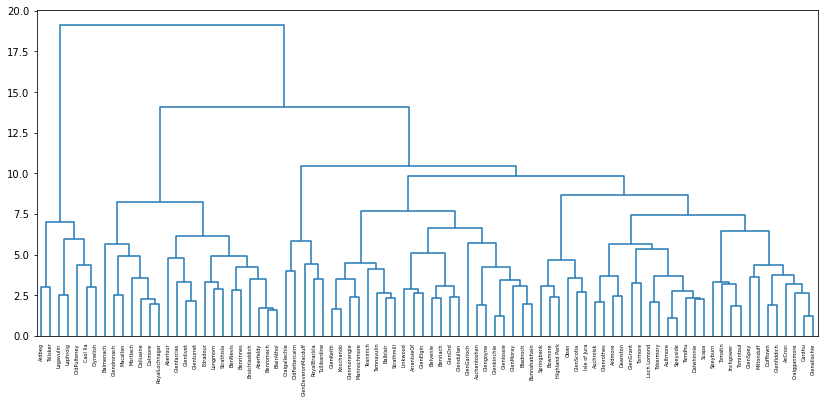

In [10]:
m = AgglomerativeClustering(compute_full_tree = True, # to decide the number of clusters
                            compute_distances = True  # to make branch length meaningful in the plot
                           ).fit(X_scaled)

plot_dendrogram(m, whiskey['distillery'].array)

Note that we used the whiskey `distillery` names to identify instances. Here we can make a decision about how many clusters we want based on the tree alone. Let's prune so that we have $k$=5 clusters:

In [11]:
m = AgglomerativeClustering(n_clusters = 5).fit(X_scaled)
m.labels_ # these are the clusters

array([2, 2, 0, 4, 0, 1, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 1, 2, 0, 2, 1, 4,
       0, 4, 3, 0, 2, 2, 0, 0, 0, 2, 3, 1, 1, 0, 1, 1, 1, 0, 0, 0, 2, 1,
       2, 0, 1, 1, 2, 1, 1, 0, 2, 0, 0, 0, 1, 4, 4, 1, 0, 2, 2, 1, 0, 2,
       0, 3, 4, 3, 2, 0, 0, 0, 0, 2, 1, 4, 0, 1, 1, 0, 0, 0, 0, 3],
      dtype=int64)

## 4. Interpretation of Clusters

Interpreting clusters usually requires domain knowledge. However, supervised learning may help us if we build an easily interpretable classifier to predict the cluster based on the other features.

First we need to compute the clusters, assign them to a column in the data frame, and make that column a Pandas' categorical column to use it as the response of a classifier. As an example, let's use the previous clustering model.

In [12]:
# Make a new column _y for the response
whiskey['_y'] = pd.Categorical(m.labels_.astype('str'))

Let's use classification trees to predict the cluster based on the 12 taste ratings:

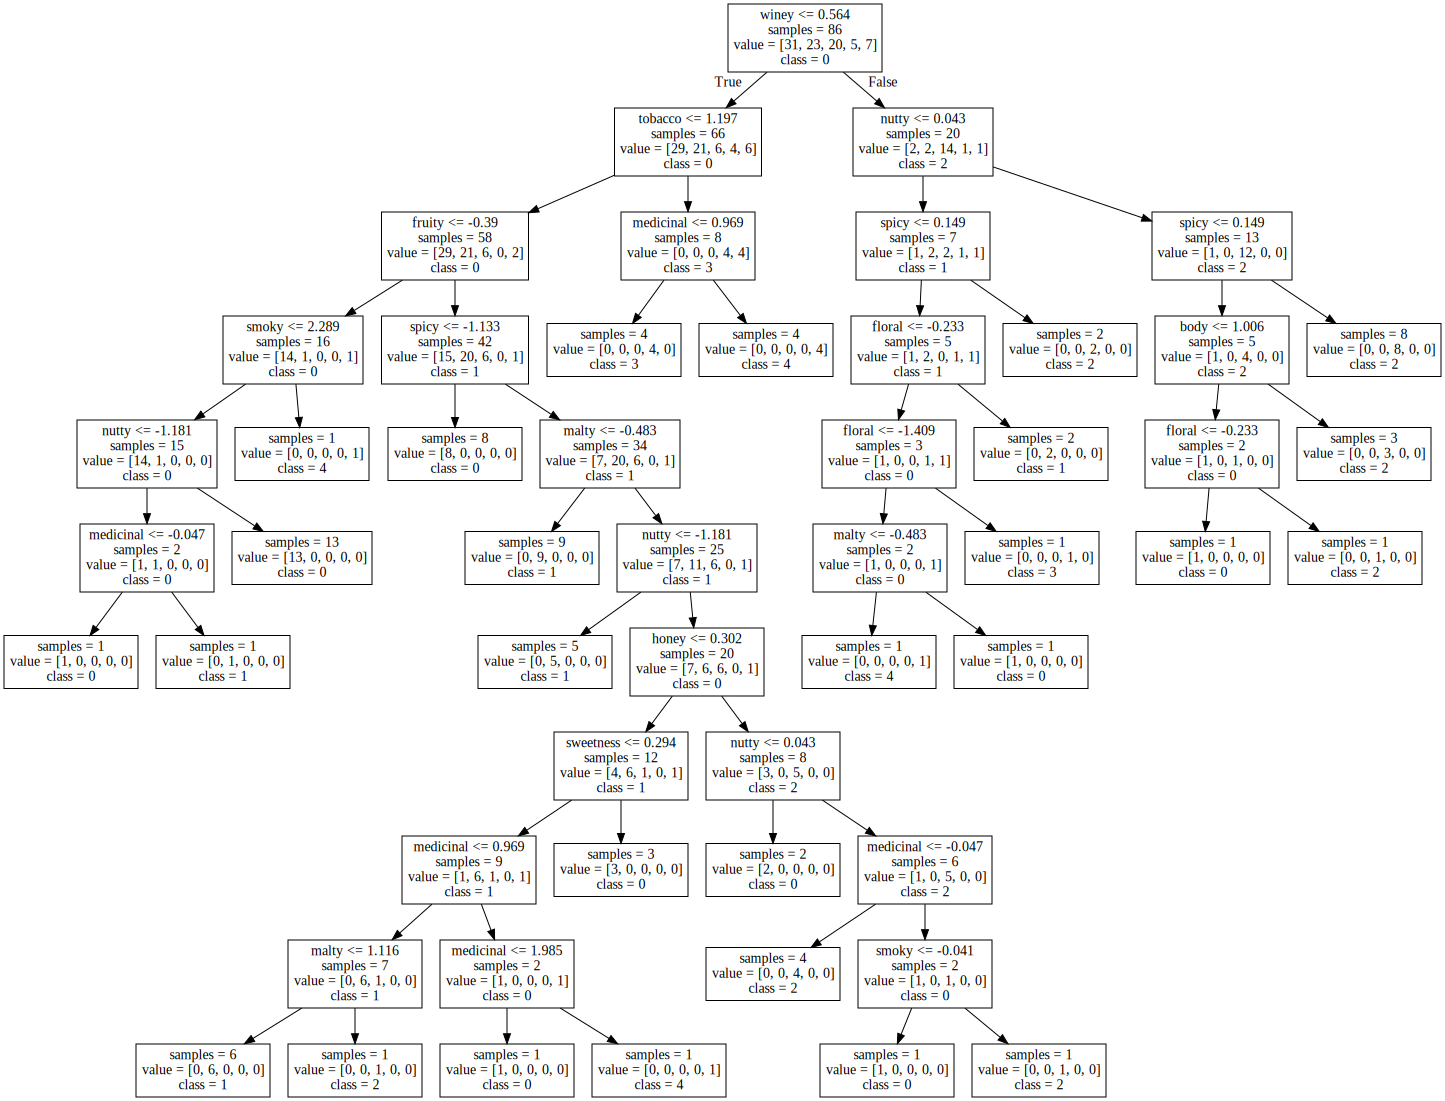

In [13]:
from sklearn import tree
import graphviz

# create tree classifier and plot it
y = whiskey['_y']
m_tree1 = tree.DecisionTreeClassifier(random_state = 12345).fit(X_scaled, y)

dot_data = tree.export_graphviz(m_tree1, feature_names = X.columns.values, class_names = y.cat.categories, \
                                impurity = False, node_ids = False)
graphviz.Source(dot_data)

Notice how we only selected column `_y` as the response, and the 12 variables we used for clustering as the features to the decision tree. Looks like this tree is too complicated to make simple descriptions of the clusters. Let's simplify by pruning with a maximum number of leaf nodes equal to the number of clusters:

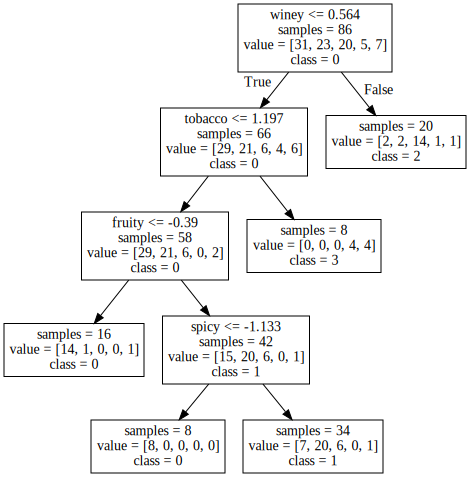

In [14]:
# create tree classifier and plot
m_tree2 = tree.DecisionTreeClassifier(max_leaf_nodes = 5, random_state = 12345).fit(X_scaled, y)

dot_data = tree.export_graphviz(m_tree2, feature_names = X.columns, class_names = y.cat.categories, \
                                impurity = False, node_ids = False)
graphviz.Source(dot_data)

This second tree is too simple, as it never predicts cluster number 4, so let's try a bit more complexity by setting the number of leaves to 6.

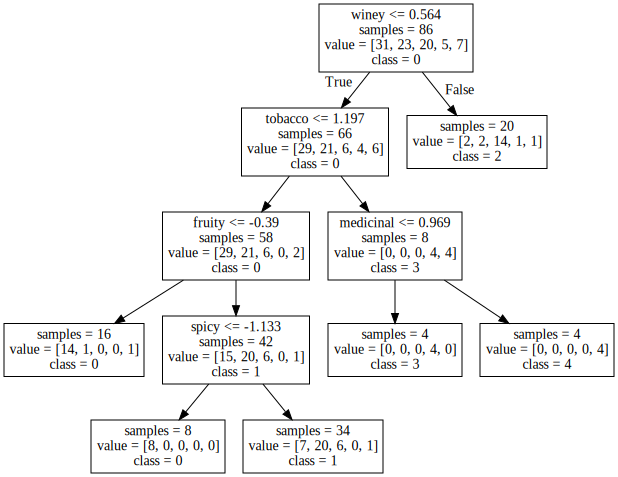

In [15]:
# create tree classifier and plot
m_tree3 = tree.DecisionTreeClassifier(max_leaf_nodes = 6).fit(X_scaled, y)

dot_data = tree.export_graphviz(m_tree3, feature_names = X.columns, class_names = y.cat.categories, \
                                impurity = False, node_ids = False)
graphviz.Source(dot_data)

This classification tree now offers us some clear and simple criteria to describe clusters. For example, cluster 2 contains whiskeys with a high winey taste (recall that variables are standardized to zero mean and unit variance). Cluster 3 contains whiskeys with very high tobacco taste but not very high medicinal taste. Such descriptions may be simplistic, but they give us some _initial insight_ as to why some whiskeys are put together in a cluster.

## 5. Principal Component Analysis

We will now use Scikit-learn's [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to build PCA models. Important uses of PCA include understanding relationships among variables, aiding in the interpretation of high-dimensional data, or simplifying supervised learning problems. In all these cases, it's important that we plot the PCA model from different perspectives, but, unfortunately again, Scikit-learn doesn't contain functions to visualize a PCA model. We will use the following custom functions for that purpose (as usual, you don't need to understand what these functions do internally; in the following we will show how to use them):

In [16]:
import matplotlib.pyplot as plt
from matplotlib import cm

def pca_summary(pca_model):
    sdev = np.sqrt(pca_model.explained_variance_)
    var_cor = np.apply_along_axis(lambda c: c*sdev, 0, pca_model.components_)
    var_cos2 = var_cor**2
    comp_cos2 = np.sum(var_cos2, 1)
    var_contrib = np.apply_along_axis(lambda c: c/comp_cos2, 0, var_cos2)
    return var_cor, var_contrib

def pca_screeplot(pca_model, figsize=(8,6)):
    """
    Shows a barplot of the fraction of variance explained by each PC.
    """
    dim = np.arange(pca_model.n_components_)
    var = pca_model.explained_variance_ratio_

    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(axis = 'y', linewidth = 0.5)
    plt.bar(dim, 100*var)
    plt.xticks(dim, dim+1)
    plt.xlabel('Component')
    plt.ylabel('Explained variance (%)')
    plt.title('Scree plot')
    plt.show()

def pca_corplot(pca_model, column_names, comp = [0,1], figsize=(6,6)):
    """
    Shows the variables in a correlation circle.
    The projection of each variable on a PC represents its correlation with that PC.
    """
    var_cor, var_contrib = pca_summary(pca_model)
    
    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(linewidth = 0.5)
    plt.axhline(linestyle='--', color='k')
    plt.axvline(linestyle='--', color='k')
    plt.gcf().gca().add_patch(plt.Circle((0,0),1,color='grey',fill=False))
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.xlabel(f'PC{comp[0]+1}')
    plt.ylabel(f'PC{comp[1]+1}')
    plt.title(f'Correlation circle PC{comp[0]+1}-PC{comp[1]+1}')

    for i in range(pca_model.n_components_):
        x = var_cor[comp[0],i]
        y = var_cor[comp[1],i]
        plt.arrow(0,0,x,y, color='k',
                 head_length=.025, head_width=.025, length_includes_head=True)
        plt.text(x,y,
                 horizontalalignment='left' if x>0 else 'right',
                 verticalalignment='bottom' if y>0 else 'top',
                 color='k', s=list(column_names)[i])
    plt.show()

def pca_contribplot(pca_model, column_names, comp = 0, figsize=(8,6)):
    """
    Shows a barplot of the contribution of each variable to a PC.
    """
    dim = np.arange(pca_model.n_components_)
    var_cor, var_contrib = pca_summary(g)
    i = (-var_contrib[comp]).argsort()

    plt.rc('axes', axisbelow=True)
    plt.grid(axis = 'y', linewidth = 0.5)
    plt.bar(dim, 100*var_contrib[comp][i])
    plt.axhline(y=100/pca_model.n_components_, linestyle='--', color='r')
    plt.xticks(dim, column_names[i])
    plt.ylabel('Contribution (%)')
    plt.title(f'Contribution of variables to PC{comp+1}')
    plt.show()

def pca_biplot(X, pca_model, column_names, comp = [0,1], clusters = None, labels = None, figsize=(12,10)):
    """
    Shows a scatterplot showing each observation in the 2D space defined by two PCs,
    along with the vectors corresponding to each feature.
    Observations can optionally be identified by a label and a color (eg. to identify clusters).
    Adapted from https://jbhender.github.io/Stats506/F17/Projects/G18.html
    """
    xvector = pca_model.components_[comp[0]]
    yvector = pca_model.components_[comp[1]]

    xs = pca_model.transform(X)[:,comp[0]]
    ys = pca_model.transform(X)[:,comp[1]]
        
    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(linewidth = 0.5)
    plt.axhline(linestyle='--', color='k')
    plt.axvline(linestyle='--', color='k')
    plt.xlim([min(xs), max(xs)])
    plt.ylim([min(ys), max(ys)])
    plt.xlabel(f'PC{comp[0]+1}')
    plt.ylabel(f'PC{comp[1]+1}')
    plt.title(f'Biplot PC{comp[0]+1}-PC{comp[1]+1}')
    
    # plot vectors
    for i in range(len(xvector)):
        x = xvector[i]*max(xs)
        y = yvector[i]*max(ys)
        plt.arrow(0, 0, x, y, color='k',
                 head_length=.1, head_width=.1, length_includes_head=True)
        plt.text(x*1.1, y*1.1, color='k', s=list(column_names)[i])

    # plot observations+
    colors = cm.get_cmap('tab10').colors
    if clusters is None:
        clusters = np.zeros(X.shape[0], dtype=int)
    if labels is None:
        labels = np.arange(X.shape[0]).astype('str')
    for i in range(len(set(clusters))):
        plt.plot(0,0, color = colors[i], label=str(i)) # only to make sure the legend appears
    plt.legend()
    for i in range(len(xs)):
        plt.text(xs[i], ys[i], color = colors[clusters[i]], label=str(clusters[i]), s = labels[i])

The _Heart_ dataset contains 6 numerical variables and 8 categorical (one of them being `ahd`, that tells us whether the patient had the disease). Let's use PCA to try and better understand these variables and, possibly, plot all the data in a 2D scatterplot. First, we build a PCA model `g` with all numerical features, standardizing again:

In [17]:
from sklearn.decomposition import PCA

# select numerical variables and standardize them
X = heart.select_dtypes('number')
X_scaled = StandardScaler().fit(X).transform(X)

# create the PCA model
g = PCA().fit(X_scaled)

We can diagnose the model with a [scree plot](https://en.wikipedia.org/wiki/Scree_plot) using our custom function `pca_screeplot`, which shows the fraction of variance explained by each of the principal components. 

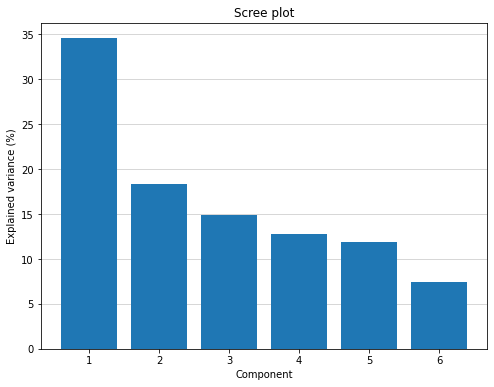

In [18]:
pca_screeplot(g)

We can see that the first principal component retains almost 35% of the total variance in the data, the second component retains about 18%, the third one 15%, etc. It appears that we can reduce the dataset to just two or three dimensions.

Let's see how the original variables relate to the principal components through a correlation circle using our custom function `pca_corplot`. In this plot, the correlation between a variable and a principal component is used as the coordinates of the variable on the component. Let's take a look at the first two components:

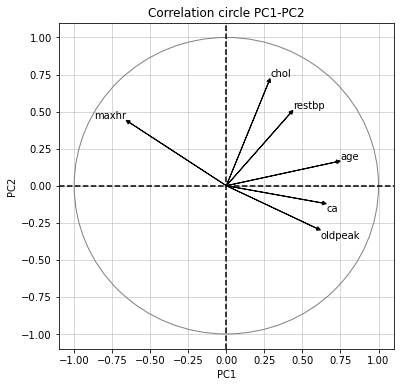

In [19]:
pca_corplot(g, X.columns.values, comp = [0,1])

We can see that `age` and `ca` have a strong positive correlation with the first component (PC1, along the _x_ axis), but not so with the second component (PC2, along the _y_ axis). However, `chol` has a strong correlation with the second component, while `restbp` and `maxhr` are mildly correlated with both PC1 and PC2.

Let's take a look at the first and third components:

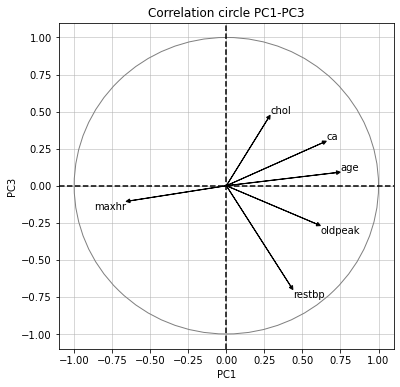

In [20]:
pca_corplot(g, X.columns.values, comp = [0,2])

The third component PC3 is mostly defined by `chol` and `restbp`, though in opposite directions.

A direct quantification of how much each variable contributes to each component is also possible to visualize with our custom function `pca_contribplot`:

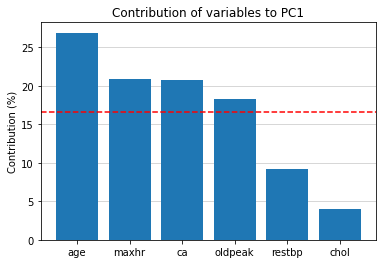

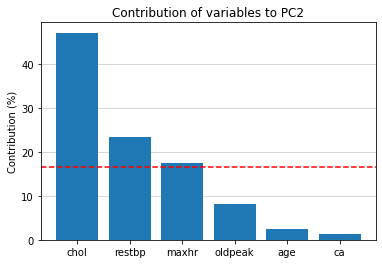

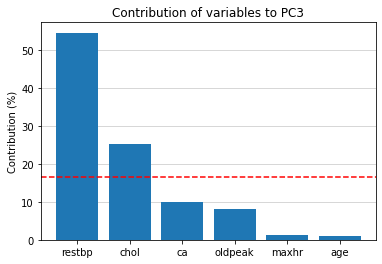

In [21]:
pca_contribplot(g, X.columns.values, comp = 0)
pca_contribplot(g, X.columns.values, comp = 1)
pca_contribplot(g, X.columns.values, comp = 2)

For instance, variable `age` contributes the most to PC1, `chol` does to PC2, and `restbp` does to PC3.

Finally, we can also make a [biplot](https://en.wikipedia.org/wiki/Biplot) to show, at the same time, where each observation is projected along two principal components, next to the vectors showing the direction of each feature along those same components. We will use our custom function `pca_biplot`, as defined above:

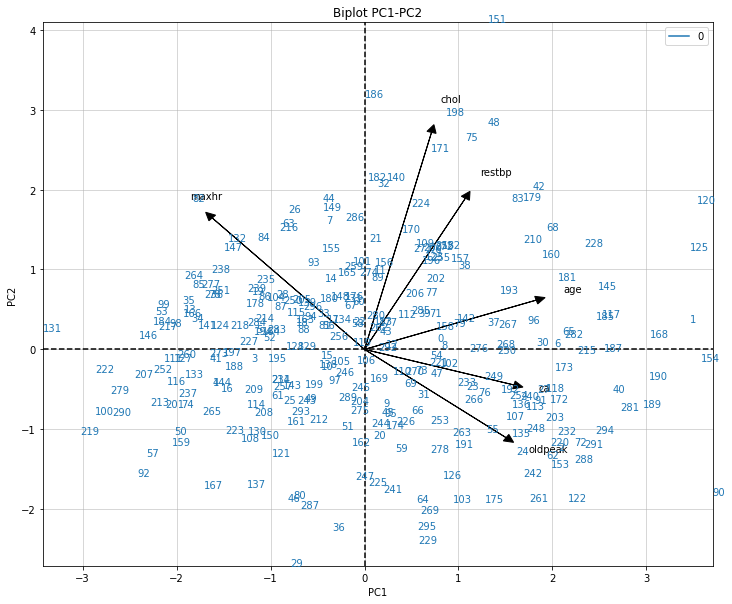

In [22]:
pca_biplot(X_scaled, g, X.columns.values, comp = [0,1])

Each number represents one observation in the dataset `X_scaled`. Biplots are very useful to understand differences and similarities among observations, interpreting their distance along the two PCs. We can therefore use them to visualize clusters in a scatterplot, as an attempt to interpret what the clusters mean.

As an example, let's recompute the clusters we made in the _Whiskey_ dataset, and plot observations in a biplot, with a color identifying the cluster, and a label identifying the distillery (note the optional arguments `clusters`and `labels` in `pca_biplot`):

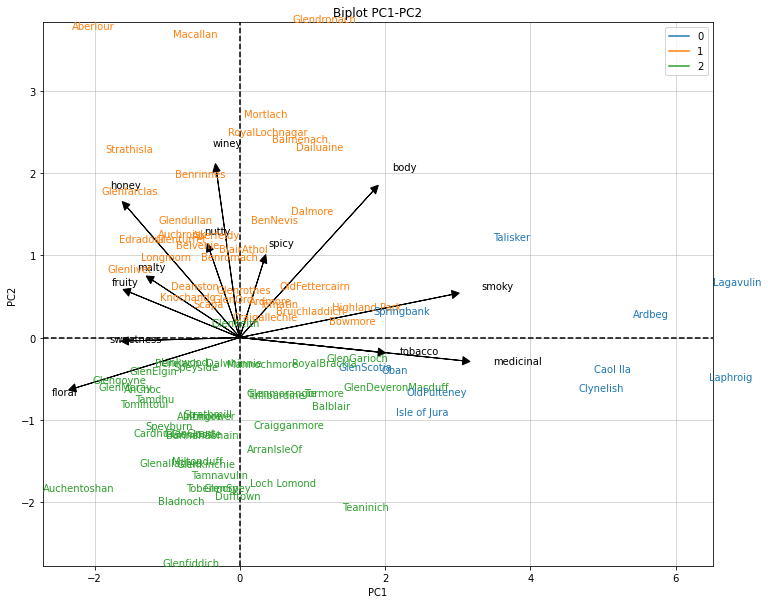

In [23]:
# prepare data
X = whiskey.loc[:, 'body':'floral']
X_scaled = StandardScaler().fit(X).transform(X)

# compute clusters
m = KMeans(n_clusters=3, random_state=12345).fit(X_scaled)
m.labels_

# perform PCA
g = PCA(n_components=2).fit(X_scaled)
X_star = g.transform(X_scaled)

# plot
pca_biplot(X_scaled, g, X.columns.values, comp = [0,1], clusters = m.labels_, labels = whiskey['distillery'])

This plot provides us yet another way to try and interpret the clusters by looking at where they are in this 2D space, and what variables are the most important along each principal component. For example, it's clear that cluster 0 scores high along PC1, which is mostly about variables `smoky` and `medicinal`. Similarly, cluster 1 scores high along PC2, which is mostly about `winey` taste and `body`. Cluster 2 scores low along PC2.

## 6. PCA for Supervised Learning

We can also use PCA to simplify a supervised learning problem. Let's build a logistic regression classifier for the _Heart_ dataset using all variables, that is, 6 numerical and 7 categorical features (refer back to the _Classification_ tutorial if necessary):

In [24]:
from sklearn.metrics import f1_score

X = heart.assign(y = heart['ahd'].cat.codes)
f = smf.glm('''y ~ sex + chestpain + fbs + restecg + exang + slope + thal +
                   age + restbp + chol + maxhr + oldpeak + ca''',
            X, family = sm.families.Binomial()).fit()
p = f.predict()
p = X['ahd'].cat.categories[np.where(p < .5, 0, 1)]

print('F-score: ', f1_score(X['ahd'], p, average = 'macro'))

F-score:  0.8704545454545454


This base model uses all 13 features and achieves an F-score of 87%.

Let’s now build a PCA model `g` to reduce the dimensionality of our dataset. Because PCA doesn’t work with categorical variables, we first have to separate the numerical variables to work with.

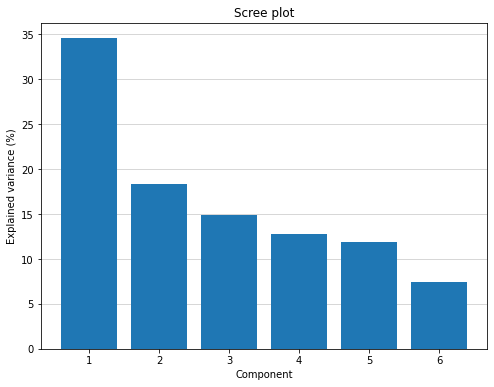

In [25]:
# separate numerical features
X_num = heart.select_dtypes('number')
# standardize prior to PCA
X_num_scaled = StandardScaler().fit(X_num).transform(X_num)

# fit PCA model g and diagnose
g = PCA().fit(X_num_scaled)
pca_screeplot(g)

It looks like with 1 or 2 dimensions we may be able to significantly reduce data and model complexity. First, we have to transform the original dataset, and then we train the logistic regression model again:

In [26]:
# transform numerical variables through g
X_num_star = pd.DataFrame(data = g.transform(X_num_scaled),
                          columns = ['PC1','PC2','PC3','PC4','PC5','PC6'])
# append the PCs to the original data
X_star = X.join(X_num_star)
X_star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ahd        297 non-null    category
 1   age        297 non-null    int64   
 2   sex        297 non-null    category
 3   chestpain  297 non-null    category
 4   restbp     297 non-null    int64   
 5   chol       297 non-null    int64   
 6   fbs        297 non-null    category
 7   restecg    297 non-null    category
 8   maxhr      297 non-null    int64   
 9   exang      297 non-null    category
 10  oldpeak    297 non-null    float64 
 11  slope      297 non-null    category
 12  ca         297 non-null    int64   
 13  thal       297 non-null    category
 14  y          297 non-null    int8    
 15  PC1        297 non-null    float64 
 16  PC2        297 non-null    float64 
 17  PC3        297 non-null    float64 
 18  PC4        297 non-null    float64 
 19  PC5        297 non-null    fl

In [27]:
# build the new model on all the categorical features and the first two PCs
f_star = smf.glm('''y ~ sex + chestpain + fbs + restecg + exang + slope + thal +
                        PC1 + PC2''',
                 X_star, family = sm.families.Binomial()).fit()
p = f_star.predict()
p = X['ahd'].cat.categories[np.where(p < .5, 0, 1)]

print('F-score: ', f1_score(X['ahd'], p, average = 'macro'))

F-score:  0.8396494089807358


We reduced the features from 13 (6 numerical, 7 categorical) to 9 (2 principal components, 7 categorical) dimensions, and the classification F-score was reduced only in 0.03 points. We could look into an ANOVA table for the new model `f_star` to see what features have the largest impact on the model, but unfortunately Statsmodels doesn't support ANOVA on GLMs. Alternatively, we can look at the regression table to get _a rough impression_:

In [28]:
f_star.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  297
Model:                            GLM   Df Residuals:                      282
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -103.78
Date:                Mon, 17 Jan 2022   Deviance:                       207.56
Time:                        01:15:17   Pearson chi2:                     267.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4941
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3863      1.816      0.213      0.832      -3.174       3.946
sex[T.woman]                -1.6119      0.494     -3.264      0.001      -2.580      -0.644
chestpain[T.atypical]       -1.0057      0.544     -1.849      0.064      -2.072       0.060
chestpain[T.non-anginal]    -1.8532      0.470     -3.941      0.000      -2.775      -0.932
chestpain[T.typical]        -2.0594      0.633     -3.252      0.001      -3.301      -0.818
fbs[T.>120]                 -0.2450      0.530     -0.463      0.644      -1.283       0.793
restecg[T.hypertrophy]       0.1069      1.577      0.068      0.946      -2.984       3.198
restecg[T.normal]           -0.3757      1.578     -0.238      0.812      -3.469       2.717
exang[T.yes]                 0.6281      0.412      1.526      0.127      -0.179       1.435
slope[T.flat]                0.5639      0.787      0.717      0.474      -0.979       2.106
slope[T.upsloping]          -0.2077      0.819     -0.253      0.800      -1.814       1.398
thal[T.normal]               0.0371      0.751      0.049      0.961      -1.434       1.508
thal[T.reversable]           1.4221      0.735      1.935      0.053      -0.018       2.863
PC1                          0.9191      0.181      5.069      0.000       0.564       1.274
PC2                         -0.1082      0.177     -0.610      0.542      -0.456       0.240
============================================================================================
"""

Judging by the $z$-scores (interpret them similar to $t$-scores), it seems that the classification is being made mostly on the basis of the first component `PC1` and the `chestpain` variable. Let’s see what happens if we only use the first principal component and the most significant categorical features:

In [29]:
f_star = smf.glm('''y ~ sex + chestpain + thal +
                        PC1''',
                 X_star, family = sm.families.Binomial()).fit()
p = f_star.predict()
p = X['ahd'].cat.categories[np.where(p < .5, 0, 1)]

print('F-score: ', f1_score(X['ahd'], p, average = 'macro'))

F-score:  0.846472838385811


In [30]:
f_star.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  297
Model:                            GLM   Df Residuals:                      289
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -109.05
Date:                Mon, 17 Jan 2022   Deviance:                       218.09
Time:                        01:15:18   Pearson chi2:                     268.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4758
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.9205      0.651      1.415      0.157      -0.355       2.196
sex[T.woman]                -1.5837      0.444     -3.569      0.000      -2.453      -0.714
chestpain[T.atypical]       -1.4822      0.513     -2.889      0.004      -2.488      -0.476
chestpain[T.non-anginal]    -2.0860      0.429     -4.865      0.000      -2.926      -1.246
chestpain[T.typical]        -2.1732      0.590     -3.680      0.000      -3.331      -1.016
thal[T.normal]              -0.2248      0.711     -0.316      0.752      -1.618       1.169
thal[T.reversable]           1.2552      0.707      1.777      0.076      -0.130       2.640
PC1                          1.0299      0.171      6.025      0.000       0.695       1.365
============================================================================================
"""

Comparing the regression summaries (eg. the pseudo-$R^2$), we see that the models are indeed pretty similar. The final model is however much simpler (only 4 features) and has virtually the same classification accuracy.

Note that we used the initial PCA model `g`, which was fitted to produce all 6 principal components when transforming via `g.transform`. Instead, we could have fitted a new PCA model with a specific dimensionality in mind (setting eg. `n_components=2`), so that when we `g.transform` a dataset we automatically get only the first two PCs. This would make the process simpler in the sense that any new instance from a test set would go through `g.transform` to directly produce only as many PCs as needed by the supervised model.